In [1]:
import os
import glob
import tempfile
import nibabel as nib
import abstract_functions as fn

In [2]:
bids_dir = fn.get_bids_data()
print(f"Downloaded BIDS data to {bids_dir}.")

Downloaded BIDS data to /tmp/bids-osf.


In [3]:
echo_times = [0.004, 0.012, 0.020, 0.028]
magnetic_field_strength = 3
tgvqsm_erosions = 3
bet_fractional_intensity = 0.5

In [4]:
session_path = os.path.join(bids_dir, "sub-1", "ses-1")
anat_path = os.path.join(session_path, "anat")
extra_data_path = os.path.join(session_path, "extra_data")
chi_file = os.path.join(extra_data_path, "sub-1_ses-1_run-01_chi-cropped.nii.gz")
segmentation_file = os.path.join(extra_data_path, "sub-1_ses-1_run-01_segmentation.nii.gz")
mag_files = sorted(glob.glob(os.path.join(anat_path, "sub-1_ses-1_run-01_echo-*_part-mag_MEGRE.nii.gz")))
pha_files = sorted(glob.glob(os.path.join(anat_path, "sub-1_ses-1_run-01_echo-*_part-phase_MEGRE.nii.gz")))
assert(len(mag_files) == len(pha_files))
tmp_dir = tempfile.gettempdir()
print(f"Found {len(mag_files)} magnitude and phase image pairs.")

Found 4 magnitude and phase image pairs.


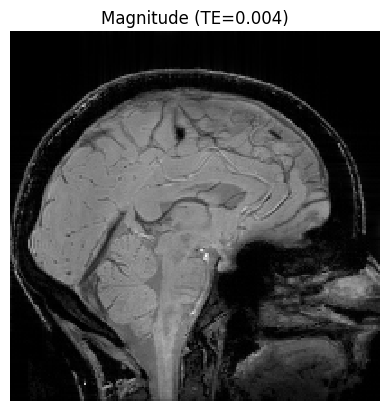

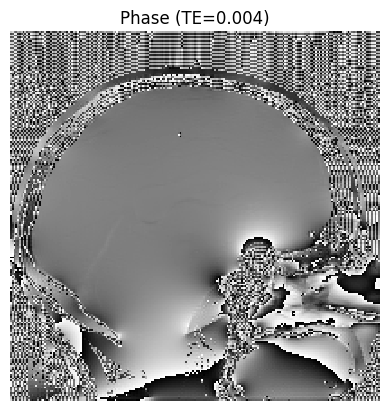

In [5]:
fn.display_nii(mag_files[0], title=f'Magnitude (TE={echo_times[0]})', cmap='gray', interpolation='nearest')
fn.display_nii(pha_files[0], title=f'Phase (TE={echo_times[0]})', cmap='gray', interpolation='nearest')

Creating rotated input images (1 degrees)
Rotating data 1 degrees and resampling...
Resampling rotated data to axial...
Creating rotated input images (2 degrees)
Rotating data 2 degrees and resampling...
Resampling rotated data to axial...
Creating rotated input images (3 degrees)
Rotating data 3 degrees and resampling...
Resampling rotated data to axial...
Creating rotated input images (4 degrees)
Rotating data 4 degrees and resampling...
Resampling rotated data to axial...
Creating rotated input images (5 degrees)
Rotating data 5 degrees and resampling...
Resampling rotated data to axial...
Creating rotated input images (10 degrees)
Rotating data 10 degrees and resampling...
Resampling rotated data to axial...
Creating rotated input images (15 degrees)
Rotating data 15 degrees and resampling...
Resampling rotated data to axial...
Creating rotated input images (20 degrees)
Rotating data 20 degrees and resampling...
Resampling rotated data to axial...
Creating rotated input images (25 

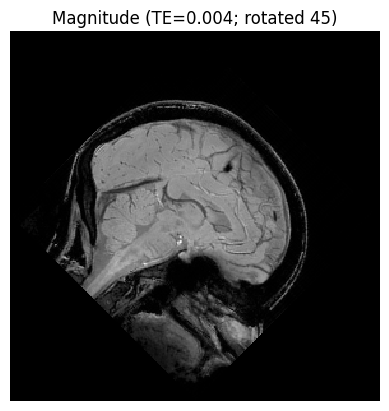

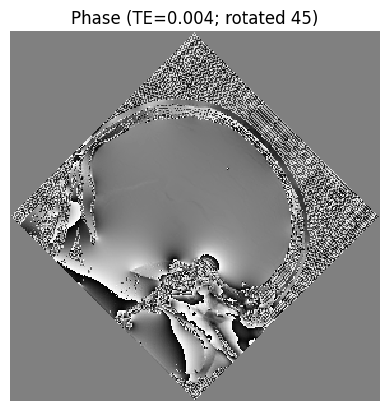

In [11]:
# create augmented data
degrees = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45]
for d in degrees:
    print(f"Creating rotated input images ({d} degrees)")
    out_dir = os.path.join(tmp_dir, f"inputs-rotated-{d}-degrees")
    print(f"Rotating data {d} degrees and resampling...")
    mag_rotated, pha_rotated = fn.rotate_mag_phase(mag_files, pha_files, out_dir, d)
    print(f"Resampling rotated data to axial...")
    mag_rotated_axial, pha_rotated_axial = fn.resample_to_axial(mag_rotated, pha_rotated, out_dir)
fn.display_nii(mag_rotated[0], title=f'Magnitude (TE={echo_times[0]}; rotated {degrees[-1]})', cmap='gray', interpolation='nearest')
fn.display_nii(pha_rotated[0], title=f'Phase (TE={echo_times[0]}; rotated {degrees[-1]})', cmap='gray', interpolation='nearest')

BET masking for original data...
QSM reconstruction for original data...


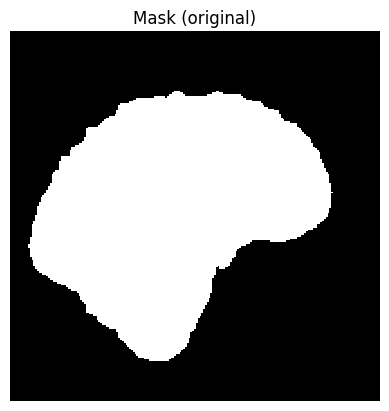

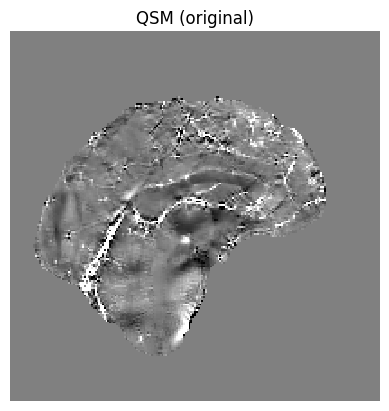

In [7]:
print("BET masking for original data...")
mask_file = fn.bet_masking(mag_files[0], bet_fractional_intensity, extra_data_path)
print("QSM reconstruction for original data...")
qsm_average_file = fn.tgv_qsm_me(mask_file, pha_files, echo_times, magnetic_field_strength, tgvqsm_erosions, extra_data_path)
fn.display_nii(mask_file, title='Mask (original)', cmap='gray', interpolation='nearest')
fn.display_nii(qsm_average_file, title='QSM (original)', cmap='gray', vmin=-0.05, vmax=+0.05, interpolation='nearest')

In [12]:

result_files = { }
for d in degrees:
    out_dir = os.path.join(extra_data_path, f"inputs-rotated-{d}-degrees")
    mag_rotated, pha_rotated = fn.rotate_mag_phase(mag_files, pha_files, out_dir, d)
    mag_rotated_axial, pha_rotated_axial = fn.resample_to_axial(mag_rotated, pha_rotated, out_dir)

    print("BET masking rotated data...")
    mask_rotated = fn.bet_masking(mag_rotated[0], bet_fractional_intensity, out_dir)
    print("Reconstructing QSM for rotated data...")
    qsm_rotated_average = fn.tgv_qsm_me(mask_rotated, pha_rotated, echo_times, magnetic_field_strength, tgvqsm_erosions, out_dir)
    #qsm_rotated_average = nextqsm_me(mask_rotated, pha_rotated, TEs, B0_str, eros, out_dir) #TODO REMOVE
    print("Resampling QSM to original space...")
    qsm_rotated_average_resampled_file = fn.resample_like(qsm_rotated_average, mag_files[0])

    print("BET masking resampled-to-axial data...")
    mask_rotated_axial = fn.bet_masking(mag_rotated_axial[0], bet_fractional_intensity, out_dir)
    print("Reconstructing QSM for resampled-to-axial data...")
    qsm_rotated_axial_average = fn.tgv_qsm_me(mask_rotated_axial, pha_rotated_axial, echo_times, magnetic_field_strength, tgvqsm_erosions, out_dir)
    #qsm_rotated_axial_average = nextqsm_me(mask_rotated_axial, pha_rotated_axial, TEs, B0_str, eros, out_dir)
    print("Resampling QSM to original space...")
    qsm_rotated_axial_average_resampled_file = fn.resample_like(qsm_rotated_axial_average, mag_files[0])
    
    result_files[d] = [qsm_rotated_axial_average_resampled_file, qsm_rotated_average_resampled_file]

In [ ]:
labels = { 
    1 : "Caudate",
    2 : "Globus pallidus",
    3 : "Putamen",
    4 : "Red nucleus",
    5 : "Dentate nucleus",
    6 : "SN and STN",
    7 : "Thalamus",
    8 : "White matter",
    9 : "Gray matter",
    10 : "CSF",
    11 : "Blood",
    12 : "Fat",
    13 : "Bone",
    14 : "Air",
    15 : "Muscle",
    16 : "Calcification"
}

# load ground truth data
segmentation = np.rot90(nib.load(segmentation_file).get_fdata())
chi = np.rot90(nib.load(chi_file).get_fdata())
qsm_average = np.rot90(nib.load(qsm_average_file).get_fdata())
chi = chi * (qsm_average != 0)
mask = qsm_average != 0

# Rotation Segmentation RMSE
print("Calculating error metrics...")
columns = ["Rotation", "Segmentation", "Corrected", "RMSE"]
rmse = np.array([0, 0, 0, mse(chi[mask], qsm_average[mask], squared=False)]).reshape(1,4)
rmse = np.append(rmse, np.array([0, 0, 1, mse(chi[mask], qsm_average[mask], squared=False)]).reshape(1,4), axis=0)
for label_id in labels.keys():
    if np.any(chi[segmentation == label_id]):
        rmse = np.append(rmse, np.array([0, label_id, 1, mse(chi[segmentation == label_id], qsm_average[segmentation == label_id], squared=False)]).reshape(1,4), axis=0)
        rmse = np.append(rmse, np.array([0, label_id, 0, mse(chi[segmentation == label_id], qsm_average[segmentation == label_id], squared=False)]).reshape(1,4), axis=0)
for d in degrees:
    print(f"Calculating error metrics for d={d}")
    qsm_corrected = np.rot90(nib.load(result_files[d][0]).get_fdata())
    qsm_uncorrected = np.rot90(nib.load(result_files[d][1]).get_fdata())
    rmse = np.append(rmse, np.array([d, 0, 1, mse(chi[mask], qsm_corrected[mask], squared=False)]).reshape(1,4), axis=0)
    rmse = np.append(rmse, np.array([d, 0, 0, mse(chi[mask], qsm_uncorrected[mask], squared=False)]).reshape(1,4), axis=0)
    for label_id in labels.keys():
        if np.any(chi[segmentation == label_id]):
            rmse = np.append(rmse, np.array([d, label_id, 1, mse(chi[segmentation == label_id], qsm_corrected[segmentation == label_id], squared=False)]).reshape(1,4), axis=0)
            rmse = np.append(rmse, np.array([d, label_id, 0, mse(chi[segmentation == label_id], qsm_uncorrected[segmentation == label_id], squared=False)]).reshape(1,4), axis=0)
rmse = pd.DataFrame(data=rmse, columns=columns)
rmse["Corrected"] = rmse["Corrected"].replace(0, "NoRot").replace(1, "RotPrior")

print("Creating line plot...")
sns.set_style("darkgrid")
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":7,"axes.labelsize":5})
fig, axes = plt.subplots(3,4)
fig.suptitle('RMSE with rotation, with and without rotate-and-resample using TGV-QSM')
fig.supxlabel('Rotation (degrees)')
fig.supylabel('RMSE (ppm)')
index = 0
for label_id in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]:
    ylim=(0.0, 0.15)
    xlim=(0, 45)
    ax = axes[int(index / 4), index % 4]
    plot = sns.lineplot(ax=ax, data=rmse[rmse.Segmentation == label_id], x="Rotation", y="RMSE", hue="Corrected")
    plot.set(xlabel=None)
    plot.set(ylabel=None)
    plot.set(ylim=ylim, xlim=xlim, title=labels[label_id] if label_id in labels else "Whole brain")
    if index < 8:
        plot.set(xticklabels=[])
    if index % 4 != 0:
        plot.set(yticklabels=[])
    plot.tick_params(axis='both', which='major', labelsize=4)
    plot.tick_params(axis='both', which='minor', labelsize=4)
    plt.xlabel("")
    plot.get_legend().remove()
    index += 1
handles, labels = plot.get_legend_handles_labels()
plot.legend(handles, labels, loc=(1.2, 3.025))
plt.savefig(f"lineplot.png", dpi=700, bbox_inches='tight')
plt.close()

print("Creating diff image figure...")
plt.figure()
sns.set_style("darkgrid")
sns.set_context("paper", rc={"font.size":13,"axes.titlesize":13,"axes.labelsize":13})
fig, axes = plt.subplots(4, 5, figsize=[10,10])
fig.suptitle('QSM computed using TGV-QSM using simulated data rotated to various angles')
slc = 102
vmin = -0.1
vmax = +0.1

axes[0,0].set_ylabel("QSM at θ", rotation=0, horizontalalignment='right')
axes[0,0].set_title("0°")
axes[0,0].imshow(qsm_average[:,:,slc], cmap='gray', vmin=vmin, vmax=vmax)
axes[0,1].set_title("5°")
axes[0,1].imshow(np.rot90(nib.load(result_files[5][1]).get_fdata()[:,:,slc]), cmap='gray', vmin=vmin, vmax=vmax)
axes[0,2].set_title("10°")
axes[0,2].imshow(np.rot90(nib.load(result_files[10][1]).get_fdata()[:,:,slc]), cmap='gray', vmin=vmin, vmax=vmax)
axes[0,3].set_title("15°")
axes[0,3].imshow(np.rot90(nib.load(result_files[15][1]).get_fdata()[:,:,slc]), cmap='gray', vmin=vmin, vmax=vmax)
axes[0,4].set_title("20°")
axes[0,4].imshow(np.rot90(nib.load(result_files[20][1]).get_fdata()[:,:,slc]), cmap='gray', vmin=vmin, vmax=vmax)

axes[1,0].set_ylabel("Diff vs. 0°", rotation=0, horizontalalignment='right')
axes[1,0].imshow(qsm_average[:,:,slc] - qsm_average[:,:,slc], cmap='seismic', vmin=vmin, vmax=vmax)
axes[1,1].imshow(qsm_average[:,:,slc] - np.rot90(nib.load(result_files[5][1]).get_fdata()[:,:,slc]), cmap='seismic', vmin=vmin, vmax=vmax)
axes[1,2].imshow(qsm_average[:,:,slc] - np.rot90(nib.load(result_files[10][1]).get_fdata()[:,:,slc]), cmap='seismic', vmin=vmin, vmax=vmax)
axes[1,3].imshow(qsm_average[:,:,slc] - np.rot90(nib.load(result_files[15][1]).get_fdata()[:,:,slc]), cmap='seismic', vmin=vmin, vmax=vmax)
axes[1,4].imshow(qsm_average[:,:,slc] - np.rot90(nib.load(result_files[20][1]).get_fdata()[:,:,slc]), cmap='seismic', vmin=vmin, vmax=vmax)

axes[2,0].set_title("25°")
axes[2,0].set_ylabel("QSM at θ", rotation=0, horizontalalignment='right')
axes[2,0].imshow(np.rot90(nib.load(result_files[25][1]).get_fdata()[:,:,slc]), cmap='gray', vmin=vmin, vmax=vmax)
axes[2,1].set_title("30°")
axes[2,1].imshow(np.rot90(nib.load(result_files[30][1]).get_fdata()[:,:,slc]), cmap='gray', vmin=vmin, vmax=vmax)
axes[2,2].set_title("35°")
axes[2,2].imshow(np.rot90(nib.load(result_files[35][1]).get_fdata()[:,:,slc]), cmap='gray', vmin=vmin, vmax=vmax)
axes[2,3].set_title("40°")
axes[2,3].imshow(np.rot90(nib.load(result_files[40][1]).get_fdata()[:,:,slc]), cmap='gray', vmin=vmin, vmax=vmax)
axes[2,4].set_title("45°")
im1 = axes[2,4].imshow(np.rot90(nib.load(result_files[45][1]).get_fdata()[:,:,slc]), cmap='gray', vmin=vmin, vmax=vmax)

axes[3,0].set_ylabel("Diff vs. 0°", rotation=0, horizontalalignment='right')
axes[3,0].imshow(qsm_average[:,:,slc] - np.rot90(nib.load(result_files[25][1]).get_fdata()[:,:,slc]), cmap='seismic', vmin=vmin, vmax=vmax)
axes[3,1].imshow(qsm_average[:,:,slc] - np.rot90(nib.load(result_files[30][1]).get_fdata()[:,:,slc]), cmap='seismic', vmin=vmin, vmax=vmax)
axes[3,2].imshow(qsm_average[:,:,slc] - np.rot90(nib.load(result_files[35][1]).get_fdata()[:,:,slc]), cmap='seismic', vmin=vmin, vmax=vmax)
axes[3,3].imshow(qsm_average[:,:,slc] - np.rot90(nib.load(result_files[40][1]).get_fdata()[:,:,slc]), cmap='seismic', vmin=vmin, vmax=vmax)
im2 = axes[3,4].imshow(qsm_average[:,:,slc] - np.rot90(nib.load(result_files[45][1]).get_fdata()[:,:,slc]), cmap='seismic', vmin=vmin, vmax=vmax)

for row in axes:
    for ax in row:
        ax.tick_params(which='both', left=False, right=False, labelbottom=False, labelleft=False, grid_alpha=0)

cax1 = fig.add_axes([0.265,0.050,0.5,0.025])
cax2 = fig.add_axes([0.265,0.075,0.5,0.025])
cax1.set_frame_on(True)
cax2.set_frame_on(True)
cbar1 = fig.colorbar(im1, orientation='horizontal', cax=cax1)
cbar2 = fig.colorbar(im2, orientation='horizontal', cax=cax2)
cbar2.set_ticks([])
cbar1.ax.locator_params(nbins=3)
cbar2.ax.locator_params(nbins=3)
cbar1.ax.tick_params(labelsize=10)
cbar2.ax.tick_params(labelsize=10)

plt.savefig(f"diff-images.png", dpi=700, bbox_inches='tight')